# Car brand identification

In [1]:
# Importing necessary libraries for PyTorch and data visualization
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"runnning on {device}")

Random Seed:  999
runnning on cpu


## Preparing the dataset

In [2]:
from customDataset import CustomDataset
from torch.utils.data import DataLoader

def create_dataloader(image_folder, data_path, batch_size=32, image_size=416):
    dataset = CustomDataset(image_folder=image_folder, data_path=data_path, image_size=image_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

country="fr"
image_folder = rf"..\..\data\images\cars\{country}"
data_path = rf"..\..\data\data\data_{country}.csv"
batch_size = 10
image_size = 416
dataloader = create_dataloader(image_folder, data_path, batch_size, image_size)
car_models = ["citroen", "peugeot", "renault"]
nb_classes=len(car_models)

In [3]:
# # Affichage des images
# batch_idx, (example_data, example_targets) = next(enumerate(dataloader))
# print("Shape of example_data:", example_data.shape)
# fig, axes = plt.subplots(2, 5, figsize=(10, 5))
# for i, ax in enumerate(axes.flat):
#     ax.imshow(example_data[i].permute(1, 2, 0), interpolation="none")
#     ax.set_title("{}".format(np.argmax(example_targets[i])))
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

## Building the network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=64 *52 * 52, out_features=128, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=128, out_features=nb_classes, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

# net = Net()
# input_data = torch.randn(13, 3, 416, 416)
# output_data = net(input_data)
# print("La taille de sortie :", output_data.size())

In [5]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.2, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=173056, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
)


## Training the model

In [6]:
# Define loss function and optimizer
log_interval = 5
train_losses = []
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (images, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        running_loss += loss.item()
        if batch_idx % log_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}, Loss: {running_loss/(batch_idx+1):.4f}")
    print(f"\tEpoch {epoch+1}, Loss: {running_loss/len(dataloader)}")

Epoch [1/2] Batch 0, Loss: 1.0963
Epoch [1/2] Batch 5, Loss: 3.4280
Epoch [1/2] Batch 10, Loss: 2.3692
Epoch [1/2] Batch 15, Loss: 1.9721
Epoch [1/2] Batch 20, Loss: 1.7642
Epoch [1/2] Batch 25, Loss: 1.6362
Epoch [1/2] Batch 30, Loss: 1.5495
	Epoch 1, Loss: 1.5353746823966503
Epoch [2/2] Batch 0, Loss: 1.0986
Epoch [2/2] Batch 5, Loss: 1.0986
Epoch [2/2] Batch 10, Loss: 1.0986
Epoch [2/2] Batch 15, Loss: 1.0986
Epoch [2/2] Batch 20, Loss: 1.0986
Epoch [2/2] Batch 25, Loss: 1.1055
Epoch [2/2] Batch 30, Loss: 1.1044
	Epoch 2, Loss: 1.1042158678174019


## Evaluating the model's Performance

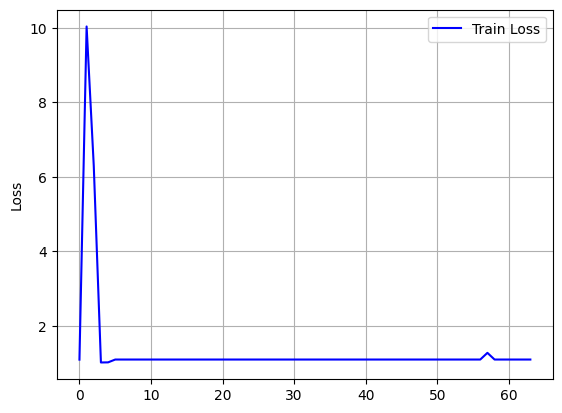

In [7]:
# Create a new figure for plotting
fig = plt.figure()

# Plot training losses as a blue line
plt.plot(train_losses, color="blue")
plt.grid(True)

# Add legend and labels
plt.legend(["Train Loss"], loc="upper right")
plt.xlabel("")
plt.ylabel("Loss")

# Display the plot
plt.show()

In [9]:
batch_idx, (example_data, example_targets) = next(enumerate(dataloader))
with torch.no_grad():
    # Disable gradient calculation
    output = model(example_data)  # Forward pass of the model with example_data
    predictions = output.argmax(dim=1)  # Calculate predictions once()

In [11]:
predictions 

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])